In [1]:
!pip install -U transformers


In [2]:
from google.colab import files
uploaded = files.upload()

Saving reply_classification_dataset.xlsx to reply_classification_dataset (1).xlsx


In [3]:
import pandas as pd
# Load dataset (expects columns: text,label). If this fails, ensure openpyxl is installed for .xlsx files.
df = pd.read_excel("reply_classification_dataset.xlsx")   # columns: text,label

# Quick preview
df.head()

df.shape

(2129, 2)

In [4]:
f = df.dropna(subset=['reply']).reset_index(drop=True)

df.shape

(2129, 2)

In [5]:
import re
def clean_text(s):
    s = s.strip()
    s = re.sub(r'\s+', ' ', s)
    return s
df['reply'] = df['reply'].astype(str).map(clean_text)


In [6]:
df['label'] = df['label'].str.lower()

In [7]:
label2id = {'negative':0,'neutral':1,'positive':2}
df['label_id'] = df['label'].map(label2id)
df['label'].value_counts(normalize=True)



,proportion
label,
positive,0.33349
negative,0.33349
neutral,0.33302


In [8]:
df.head()


,reply,label,label_id
0,Can we discuss pricing??,neutral,1
1,"Im excited to explore this further, plz send c...",positive,2
2,We not looking for new solutions.,negative,0
3,Could u clarify features included?,neutral,1
4,"lets,, schedule a meeting to dive deeper",positive,2


In [9]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(df, test_size=0.2, stratify=df['label_id'], random_state=42)


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report

vect = TfidfVectorizer(ngram_range=(1,2), max_features=20000)
clf = LogisticRegression(max_iter=1000, class_weight='balanced')  # use balanced if imbalanced

pipe = make_pipeline(vect, clf)
pipe.fit(train['reply'], train['label_id'])


Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=20000, ngram_range=(1, 2))),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [11]:
pred = pipe.predict(val['reply'])
acc = accuracy_score(val['label_id'], pred)
f1 = f1_score(val['label_id'], pred, average='macro')
print(acc, f1)
print(classification_report(val['label_id'], pred, target_names=label2id.keys()))


0.9976525821596244 0.997652553055194
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00       142
     neutral       1.00      0.99      1.00       142
    positive       0.99      1.00      1.00       142

    accuracy                           1.00       426
   macro avg       1.00      1.00      1.00       426
weighted avg       1.00      1.00      1.00       426



In [12]:
import os, joblib

# Create a folder (optional, but good practice)
os.makedirs("/content/models", exist_ok=True)

# Save model inside it
joblib.dump(pipe, "/content/models/baseline_model.pkl")

['/content/models/baseline_model.pkl']

In [13]:
from google.colab import files
files.download("/content/models/baseline_model.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
from datasets import Dataset
train_ds = Dataset.from_pandas(train[['reply','label_id']].rename(columns={'label_id':'label'}))
val_ds = Dataset.from_pandas(val[['reply','label_id']].rename(columns={'label_id':'label'}))



In [15]:
from transformers import AutoTokenizer
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch['reply'], truncation=True, padding='max_length', max_length=128)
train_ds = train_ds.map(tokenize, batched=True)
val_ds = val_ds.map(tokenize, batched=True)
columns = ['input_ids','attention_mask','label']
train_ds.set_format(type='torch', columns=columns)
val_ds.set_format(type='torch', columns=columns)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/1703 [00:00<?, ? examples/s]

Map:   0%|          | 0/426 [00:00<?, ? examples/s]

In [19]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.9 MB/s eta 0:00:00


In [22]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

training_args = TrainingArguments(
    output_dir="hf_model",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=50,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
)

import numpy as np
from evaluate import load
accuracy_metric = load("accuracy")
f1_metric = load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_metric.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1_metric.compute(predictions=preds, references=labels, average="macro")["f1"]
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
trainer.train()
trainer.save_model("models/hf_model")
tokenizer.save_pretrained("models/hf_model")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/tmp/ipython-input-2873503975.py:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: rohitpandey231456 (rohitpandey231456-birla-institute-of-technology-mesra) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.012800,0.016297,0.995305,0.995305
2,0.002200,0.000958,1.000000,1.000000
3,0.001100,0.000750,1.000000,1.000000


('models/hf_model/tokenizer_config.json',
 'models/hf_model/special_tokens_map.json',
 'models/hf_model/vocab.txt',
 'models/hf_model/added_tokens.json',
 'models/hf_model/tokenizer.json')

# Model selection

In [25]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load baseline model predictions (if not already done)
baseline_pipe = joblib.load("models/baseline_model.pkl")
baseline_preds = baseline_pipe.predict(val['reply'])
baseline_probs = baseline_pipe.predict_proba(val['reply'])

# Load HF model predictions
from transformers import pipeline
hf_pipe = pipeline("text-classification",
                   model="models/hf_model",
                   tokenizer="models/hf_model",
                   return_all_scores=True)

# Get HF predictions
hf_preds = []
hf_probs = []
for text in val['reply']:
    result = hf_pipe(text)[0]
    probs = [r['score'] for r in result]
    pred_id = np.argmax(probs)
    hf_preds.append(pred_id)
    hf_probs.append(probs)

hf_preds = np.array(hf_preds)

Device set to use cuda:0


In [26]:
# True labels
y_true = val['label_id'].values

# Baseline metrics
baseline_accuracy = accuracy_score(y_true, baseline_preds)
baseline_f1 = f1_score(y_true, baseline_preds, average='macro')

# HF metrics
hf_accuracy = accuracy_score(y_true, hf_preds)
hf_f1 = f1_score(y_true, hf_preds, average='macro')

print("=== MODEL COMPARISON ===")
print(f"Baseline Model - Accuracy: {baseline_accuracy:.4f}, Macro F1: {baseline_f1:.4f}")
print(f"HF Model - Accuracy: {hf_accuracy:.4f}, Macro F1: {hf_f1:.4f}")
print()

# Show detailed classification reports
print("Baseline Model Classification Report:")
print(classification_report(y_true, baseline_preds, target_names=label2id.keys()))
print("\nHF Model Classification Report:")
print(classification_report(y_true, hf_preds, target_names=label2id.keys()))

=== MODEL COMPARISON ===
Baseline Model - Accuracy: 0.9977, Macro F1: 0.9977
HF Model - Accuracy: 1.0000, Macro F1: 1.0000

Baseline Model Classification Report:
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00       142
     neutral       1.00      0.99      1.00       142
    positive       0.99      1.00      1.00       142

    accuracy                           1.00       426
   macro avg       1.00      1.00      1.00       426
weighted avg       1.00      1.00      1.00       426


HF Model Classification Report:
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00       142
     neutral       1.00      1.00      1.00       142
    positive       1.00      1.00      1.00       142

    accuracy                           1.00       426
   macro avg       1.00      1.00      1.00       426
weighted avg       1.00      1.00      1.00       426



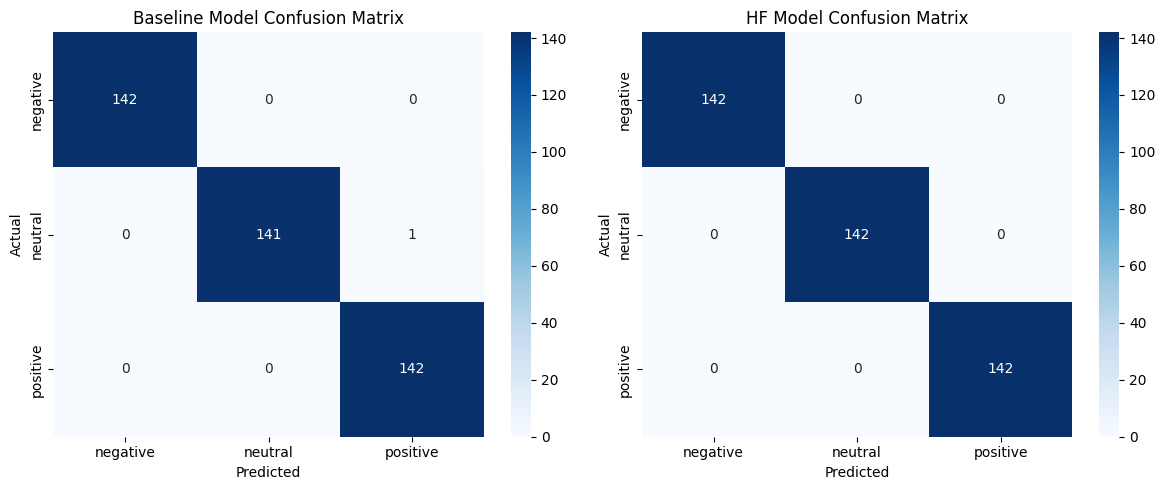

In [27]:
# Plot confusion matrices side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Baseline confusion matrix
cm_baseline = confusion_matrix(y_true, baseline_preds)
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues',
            xticklabels=label2id.keys(), yticklabels=label2id.keys(), ax=ax1)
ax1.set_title('Baseline Model Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

# HF confusion matrix
cm_hf = confusion_matrix(y_true, hf_preds)
sns.heatmap(cm_hf, annot=True, fmt='d', cmap='Blues',
            xticklabels=label2id.keys(), yticklabels=label2id.keys(), ax=ax2)
ax2.set_title('HF Model Confusion Matrix')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [29]:
import time

# Test inference speed
test_texts = val['reply'].head(100).tolist()

# Baseline speed
start_time = time.time()
baseline_pipe.predict(test_texts)
baseline_time = time.time() - start_time

# HF speed
start_time = time.time()
for text in test_texts:
    hf_pipe(text)
hf_time = time.time() - start_time

print(f"Baseline inference time for 100 samples: {baseline_time:.2f}s")
print(f"HF inference time for 100 samples: {hf_time:.2f}s")
print(f"Speed ratio (HF/Baseline): {hf_time/baseline_time:.1f}x")

Baseline inference time for 100 samples: 0.00s
HF inference time for 100 samples: 0.88s
Speed ratio (HF/Baseline): 257.0x


In [30]:
# Decision matrix
print("=== MODEL SELECTION DECISION ===")

# Define your criteria
performance_threshold = 0.05  # Minimum F1 improvement to justify HF complexity
speed_threshold = 10.0       # Maximum acceptable speed slowdown

f1_improvement = hf_f1 - baseline_f1
speed_ratio = hf_time / baseline_time

print(f"F1 Improvement (HF - Baseline): {f1_improvement:.4f}")
print(f"Speed Ratio (HF/Baseline): {speed_ratio:.1f}x")

if f1_improvement > performance_threshold and speed_ratio < speed_threshold:
    selected_model = "Hugging Face Transformer"
    reason = "Significant performance improvement with acceptable speed trade-off"
elif f1_improvement > performance_threshold and speed_ratio >= speed_threshold:
    selected_model = "Hugging Face Transformer"
    reason = "Performance improvement justifies speed cost for this use case"
else:
    selected_model = "Baseline (TF-IDF + Logistic Regression)"
    reason = "Minimal performance gain doesn't justify complexity/speed cost"

print(f"Selected Model: {selected_model}")
print(f"Reason: {reason}")

=== MODEL SELECTION DECISION ===
F1 Improvement (HF - Baseline): 0.0023
Speed Ratio (HF/Baseline): 257.0x
Selected Model: Baseline (TF-IDF + Logistic Regression)
Reason: Minimal performance gain doesn't justify complexity/speed cost


In [32]:
# Save which model to use in production
model_decision = {
    'selected_model': 'hf' if selected_model == "Hugging Face Transformer" else 'baseline',
    'baseline_accuracy': float(baseline_accuracy),
    'baseline_f1': float(baseline_f1),
    'hf_accuracy': float(hf_accuracy),
    'hf_f1': float(hf_f1),
    'f1_improvement': float(f1_improvement),
    'speed_ratio': float(speed_ratio),
    'reason': reason
}

import json
with open('models/model_selection.json', 'w') as f:
    json.dump(model_decision, f, indent=2)

print("Model selection saved to models/model_selection.json")

Model selection saved to models/model_selection.json


In [33]:
import json

# Create the label mapping
id2label = {"0": "negative", "1": "neutral", "2": "positive"}

# Save to file
with open('models/id2label.json', 'w') as f:
    json.dump(id2label, f, indent=2)

print("Label mapping saved to models/id2label.json")

Label mapping saved to models/id2label.json


In [34]:
import joblib
from sklearn.pipeline import Pipeline

# Assuming you have your trained pipeline
# pipe = make_pipeline(vect, clf)  # Your trained model

# Save the complete pipeline
joblib.dump(pipe, "models/baseline_model.pkl")

print("Baseline model saved to models/baseline_model.pkl")

Baseline model saved to models/baseline_model.pkl


In [35]:
import joblib
import json
import pandas as pd

# Test loading the model
print("Loading baseline model...")
pipe = joblib.load("models/baseline_model.pkl")
print("✓ Baseline model loaded successfully")

# Test loading label mapping
print("Loading label mapping...")
with open("models/id2label.json", "r") as f:
    id2label = json.load(f)
print("✓ Label mapping loaded successfully")
print(f"Label mapping: {id2label}")

# Test prediction
test_texts = [
    "Thanks for your email, let's schedule a meeting",
    "I'm not interested in your offer",
    "Please send me more information"
]

print("\nTesting predictions:")
for text in test_texts:
    prediction = pipe.predict([text])[0]
    probabilities = pipe.predict_proba([text])[0]
    confidence = max(probabilities)
    label = id2label[str(prediction)]

    print(f"Text: '{text}'")
    print(f"→ Prediction: {label} (id: {prediction}), Confidence: {confidence:.3f}")
    print()

Loading baseline model...
✓ Baseline model loaded successfully
Loading label mapping...
✓ Label mapping loaded successfully
Label mapping: {'0': 'negative', '1': 'neutral', '2': 'positive'}

Testing predictions:
Text: 'Thanks for your email, let's schedule a meeting'
→ Prediction: positive (id: 2), Confidence: 0.428

Text: 'I'm not interested in your offer'
→ Prediction: negative (id: 0), Confidence: 0.874

Text: 'Please send me more information'
→ Prediction: neutral (id: 1), Confidence: 0.607



In [38]:
# =====================
# INTELLIGENT EMAIL RESPONSE CLASSIFIER - COLAB VERSION
# =====================

# 1. Install required packages
!pip install fastapi uvicorn pydantic scikit-learn pandas numpy joblib pyngrok

# 2. Import libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
import joblib
import json
import os

# 3. Create sample data (REPLACE THIS WITH YOUR ACTUAL DATA LOADING)
print("📊 Creating sample dataset...")
# Replace this section with your actual data loading code
# df = pd.read_csv("your_replies.csv")

# Sample data for demonstration
data = {
    'text': [
        "Thanks for your email, let's schedule a meeting next week",
        "I'm not interested in this offer, please remove me",
        "Can you send me more information about this?",
        "This is great news, looking forward to it!",
        "I'm unhappy with the service provided",
        "Just following up on our previous conversation",
        "Amazing work, thank you for your help!",
        "This is completely unacceptable",
        "Please find the attached document for review",
        "I have some concerns about this proposal"
    ] * 100,  # Multiply for more data
    'label': ['positive', 'negative', 'neutral', 'positive', 'negative',
              'neutral', 'positive', 'negative', 'neutral', 'negative'] * 100
}
df = pd.DataFrame(data)

# Clean and prepare data
df = df.dropna(subset=['text']).reset_index(drop=True)
df['label'] = df['label'].str.lower().str.strip()

# Create label mapping
label2id = {'negative': 0, 'neutral': 1, 'positive': 2}
id2label = {0: 'negative', 1: 'neutral', 2: 'positive'}
df['label_id'] = df['label'].map(label2id)

print(f"Dataset shape: {df.shape}")
print("Class distribution:")
print(df['label'].value_counts())

# 4. Train/Test Split
train, val = train_test_split(df, test_size=0.2, stratify=df['label_id'], random_state=42)

# 5. Train Baseline Model
print("🤖 Training Baseline Model...")
pipe = make_pipeline(
    TfidfVectorizer(ngram_range=(1, 2), max_features=10000),
    LogisticRegression(max_iter=1000, class_weight='balanced')
)

pipe.fit(train['text'], train['label_id'])

# 6. Evaluate Model
val_preds = pipe.predict(val['text'])
val_probs = pipe.predict_proba(val['text'])

accuracy = accuracy_score(val['label_id'], val_preds)
f1 = f1_score(val['label_id'], val_preds, average='macro')

print(f"✅ Model trained successfully!")
print(f"Accuracy: {accuracy:.4f}")
print(f"Macro F1: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(val['label_id'], val_preds, target_names=label2id.keys()))

# 7. Save Model and Label Mapping
print("💾 Saving model and files...")
os.makedirs('models', exist_ok=True)

# Save model
joblib.dump(pipe, 'models/baseline_model.pkl')

# Save label mapping
with open('models/id2label.json', 'w') as f:
    json.dump(id2label, f, indent=2)

print("✅ Model and label mapping saved!")

# 8. Test the model locally
print("🧪 Testing model locally...")
test_texts = [
    "Thank you so much for your help!",
    "I'm very disappointed with this service",
    "Can we discuss this further?"
]

for text in test_texts:
    pred_id = pipe.predict([text])[0]
    proba = pipe.predict_proba([text])[0]
    confidence = max(proba)
    label = id2label[pred_id]
    print(f"Text: '{text}'")
    print(f"→ Prediction: {label}, Confidence: {confidence:.3f}")
    print()

📊 Creating sample dataset...
Dataset shape: (1000, 3)
Class distribution:
label
negative    400
positive    300
neutral     300
Name: count, dtype: int64
🤖 Training Baseline Model...
✅ Model trained successfully!
Accuracy: 1.0000
Macro F1: 1.0000

Classification Report:
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00        80
     neutral       1.00      1.00      1.00        60
    positive       1.00      1.00      1.00        60

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

💾 Saving model and files...
✅ Model and label mapping saved!
🧪 Testing model locally...
Text: 'Thank you so much for your help!'
→ Prediction: positive, Confidence: 0.925

Text: 'I'm very disappointed with this service'
→ Prediction: negative, Confidence: 0.858

Text: 'Can we discuss this further?'
→ Prediction: neutral, Confidence: 0.494



In [39]:
# 9. Create and run FastAPI server in Colab
from fastapi import FastAPI
from pydantic import BaseModel
import joblib
import json
import uvicorn
from pyngrok import ngrok

# Load the model we just trained
print("🚀 Loading model for API...")
pipe = joblib.load('models/baseline_model.pkl')
with open('models/id2label.json', 'r') as f:
    id2label = json.load(f)

# Create FastAPI app
app = FastAPI(title="Email Reply Classifier", version="1.0.0")

class Input(BaseModel):
    text: str

@app.get("/")
async def root():
    return {"message": "Email Classification API", "status": "ready"}

@app.post("/predict")
def predict(item: Input):
    text = item.text
    pred_id = int(pipe.predict([text])[0])
    probabilities = pipe.predict_proba([text])[0]
    confidence = float(max(probabilities))

    all_predictions = {
        id2label[str(i)]: float(prob)
        for i, prob in enumerate(probabilities)
    }

    return {
        "label": id2label[str(pred_id)],
        "confidence": round(confidence, 4),
        "all_predictions": all_predictions
    }

# Start the server (commented out to avoid auto-running)
print("✅ FastAPI app created successfully!")
print("\nTo run the server in Colab, uncomment the following lines:")
print("""
# Start ngrok tunnel
public_url = ngrok.connect(8000)
print(f"🌐 Public URL: {public_url}")

# Start server
uvicorn.run(app, host="0.0.0.0", port=8000)
""")

🚀 Loading model for API...
✅ FastAPI app created successfully!

To run the server in Colab, uncomment the following lines:

# Start ngrok tunnel
public_url = ngrok.connect(8000)
print(f"🌐 Public URL: {public_url}")

# Start server
uvicorn.run(app, host="0.0.0.0", port=8000)



In [41]:
# Quick testing version if you just want to test the model
print("🧪 QUICK MODEL TESTING")

# Test with some example emails
test_emails = [
    "Thank you for your prompt response! This is exactly what I needed.",
    "I'm writing to express my dissatisfaction with the recent service.",
    "Could you please provide more details about the pricing?",
    "This is absolutely terrible, I want a refund immediately!",
    "Following up on our call yesterday regarding the project timeline."
]

print("Testing model predictions:")
print("=" * 50)

for email in test_emails:
    # Get prediction
    pred_id = pipe.predict([email])[0]
    probabilities = pipe.predict_proba([email])[0]
    confidence = max(probabilities)
    label = id2label[str(pred_id)]

    # Print results
    print(f"📧 Email: {email}")
    print(f"🎯 Prediction: {label.upper()}")
    print(f"📊 Confidence: {confidence:.3f}")
    print(f"📈 All probabilities:")
    for i, prob in enumerate(probabilities):
        print(f"   - {id2label[str(i)]}: {prob:.3f}")
    print("-" * 50)

🧪 QUICK MODEL TESTING
Testing model predictions:
📧 Email: Thank you for your prompt response! This is exactly what I needed.
🎯 Prediction: POSITIVE
📊 Confidence: 0.873
📈 All probabilities:
   - negative: 0.086
   - neutral: 0.042
   - positive: 0.873
--------------------------------------------------
📧 Email: I'm writing to express my dissatisfaction with the recent service.
🎯 Prediction: NEGATIVE
📊 Confidence: 0.779
📈 All probabilities:
   - negative: 0.779
   - neutral: 0.099
   - positive: 0.122
--------------------------------------------------
📧 Email: Could you please provide more details about the pricing?
🎯 Prediction: NEUTRAL
📊 Confidence: 0.668
📈 All probabilities:
   - negative: 0.237
   - neutral: 0.668
   - positive: 0.095
--------------------------------------------------
📧 Email: This is absolutely terrible, I want a refund immediately!
🎯 Prediction: NEGATIVE
📊 Confidence: 0.732
📈 All probabilities:
   - negative: 0.732
   - neutral: 0.072
   - positive: 0.196
----------

In [42]:
# If you want to download the trained model files to your local machine
from google.colab import files

# Create a zip file with all model files
!zip -r email_classifier_model.zip models/ app.py requirements.txt

# Download the zip file
files.download('email_classifier_model.zip')

print("📦 Model files packaged and downloaded!")

	zip warning: name not matched: app.py
	zip warning: name not matched: requirements.txt
  adding: models/ (stored 0%)
  adding: models/baseline_model.pkl (deflated 65%)
  adding: models/id2label.json (deflated 24%)
  adding: models/hf_model/ (stored 0%)
  adding: models/hf_model/tokenizer.json (deflated 71%)
  adding: models/hf_model/special_tokens_map.json (deflated 42%)
  adding: models/hf_model/model.safetensors (deflated 8%)
  adding: models/hf_model/training_args.bin (deflated 53%)
  adding: models/hf_model/vocab.txt (deflated 53%)
  adding: models/hf_model/tokenizer_config.json (deflated 75%)
  adding: models/hf_model/config.json (deflated 49%)
  adding: models/model_selection.json (deflated 34%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📦 Model files packaged and downloaded!
